# CST2101 – Business Intelligence Programming
# Final Project – Phase 2
# Title: Ontario Electricity Demand & Price Early-Warning Dashboard
# Student: Chintankumar Domadiya
# Student Number: 041191137

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import statsmodels.api as sm

plt.style.use("seaborn-v0_8")

## Load the CSV (skip the text rows)

In [2]:
# Path to your CSV (relative to notebook)
csv_path = r"D:\CST2101_EnergyDashboard\data\raw\ontario_demand_20251114.csv"

# The first 4 lines in the file are text, not column names.
# We skip them and read from the header row that starts with HOUR, INTERVAL, etc.
df = pd.read_csv(csv_path, skiprows=4)

df.head()

,HOUR,INTERVAL,TOTAL ENERGY,TOTAL LOSS,TOTAL LOAD,TOTAL DISP LOAD SCHED OFF,TOTAL 10S,TOTAL 10N,TOTAL 30R,FLAG
0,6,1,17287.4,363.7,16923.7,112.4,236,813.0,369.0,DSO-RD
1,6,2,17419.5,371.1,17048.3,110.8,236,773.0,409.0,DSO-RD
2,6,3,17357.6,367.5,16990.2,105.8,236,773.0,409.0,DSO-RD
3,6,4,17386.4,366.4,17020.0,100.8,236,773.0,409.0,DSO-RD
4,6,5,17383.6,361.8,17021.8,96.9,236,773.0,409.0,DSO-RD


## Basic info and rename main column

In [3]:
df.info()
print(df.head())

# Rename columns to simpler names
df = df.rename(
    columns={
        "HOUR": "hour",
        "INTERVAL": "interval",
        "TOTAL ENERGY": "total_energy",
        "TOTAL LOSS": "total_loss",
        "TOTAL LOAD": "demand_mw"
        # you can rename other columns later if needed
    }
)

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   HOUR                       12 non-null     int64  
 1   INTERVAL                   12 non-null     int64  
 2   TOTAL ENERGY               12 non-null     float64
 3   TOTAL LOSS                 12 non-null     float64
 4   TOTAL LOAD                 12 non-null     float64
 5   TOTAL DISP LOAD SCHED OFF  12 non-null     float64
 6   TOTAL 10S                  12 non-null     int64  
 7   TOTAL 10N                  12 non-null     float64
 8   TOTAL 30R                  12 non-null     float64
 9   FLAG                       12 non-null     object 
dtypes: float64(6), int64(3), object(1)
memory usage: 1.1+ KB
   HOUR  INTERVAL  TOTAL ENERGY  TOTAL LOSS  TOTAL LOAD  \
0     6         1       17287.4       363.7     16923.7   
1     6         2       17419.5       371.1  

,hour,interval,total_energy,total_loss,demand_mw,TOTAL DISP LOAD SCHED OFF,TOTAL 10S,TOTAL 10N,TOTAL 30R,FLAG
0,6,1,17287.4,363.7,16923.7,112.4,236,813.0,369.0,DSO-RD
1,6,2,17419.5,371.1,17048.3,110.8,236,773.0,409.0,DSO-RD
2,6,3,17357.6,367.5,16990.2,105.8,236,773.0,409.0,DSO-RD
3,6,4,17386.4,366.4,17020.0,100.8,236,773.0,409.0,DSO-RD
4,6,5,17383.6,361.8,17021.8,96.9,236,773.0,409.0,DSO-RD


## Create timestamp from HOUR + INTERVAL

In [4]:
# Set the date for this file (change if your file is a different date)
file_date = "2025-11-14"

# Each interval is 5 minutes. Interval 1 = minute 0, 2 = minute 5, ..., 12 = minute 55
df["minute"] = (df["interval"] - 1) * 5

# Build timestamp: date + hour + minute
df["timestamp"] = pd.to_datetime(file_date) \
                  + pd.to_timedelta(df["hour"], unit="h") \
                  + pd.to_timedelta(df["minute"], unit="m")

# Sort by time
df = df.sort_values("timestamp").reset_index(drop=True)

df[["timestamp", "hour", "interval", "demand_mw"]].head(15)

,timestamp,hour,interval,demand_mw
0,2025-11-14 06:00:00,6,1,16923.7
1,2025-11-14 06:05:00,6,2,17048.3
2,2025-11-14 06:10:00,6,3,16990.2
3,2025-11-14 06:15:00,6,4,17020.0
4,2025-11-14 06:20:00,6,5,17021.8
5,2025-11-14 06:25:00,6,6,17051.3
6,2025-11-14 06:30:00,6,7,17102.5
7,2025-11-14 06:35:00,6,8,17145.7
8,2025-11-14 06:40:00,6,9,17227.9
9,2025-11-14 06:45:00,6,10,17242.1


## Basic cleaning

In [5]:
# Check missing values
print("Missing values per column:")
print(df.isna().sum())

# Drop duplicates just in case
df = df.drop_duplicates(subset=["timestamp"])

# Drop rows where demand is missing
df = df.dropna(subset=["demand_mw"])

print("Data shape after cleaning:", df.shape)


Missing values per column:
hour                         0
interval                     0
total_energy                 0
total_loss                   0
demand_mw                    0
TOTAL DISP LOAD SCHED OFF    0
TOTAL 10S                    0
TOTAL 10N                    0
TOTAL 30R                    0
FLAG                         0
minute                       0
timestamp                    0
dtype: int64
Data shape after cleaning: (12, 12)


## Simple feature engineering

In [6]:
df["hour_of_day"] = df["timestamp"].dt.hour
df["minute_of_hour"] = df["timestamp"].dt.minute

df[["timestamp", "hour_of_day", "minute_of_hour", "demand_mw"]].head()

,timestamp,hour_of_day,minute_of_hour,demand_mw
0,2025-11-14 06:00:00,6,0,16923.7
1,2025-11-14 06:05:00,6,5,17048.3
2,2025-11-14 06:10:00,6,10,16990.2
3,2025-11-14 06:15:00,6,15,17020.0
4,2025-11-14 06:20:00,6,20,17021.8


## EDA: time-series plot (5-minute data)

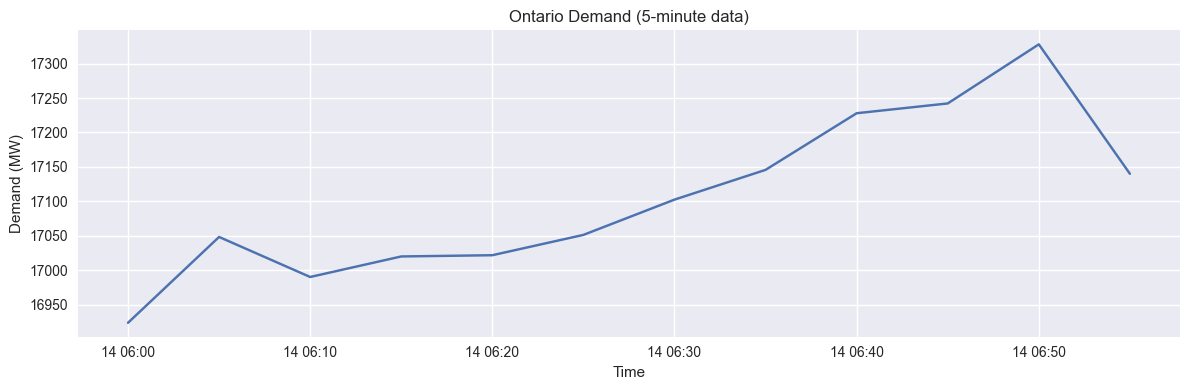

In [7]:
plt.figure(figsize=(12, 4))
plt.plot(df["timestamp"], df["demand_mw"])
plt.title("Ontario Demand (5-minute data)")
plt.xlabel("Time")
plt.ylabel("Demand (MW)")
plt.tight_layout()
plt.show()

## EDA: average demand by hour of day

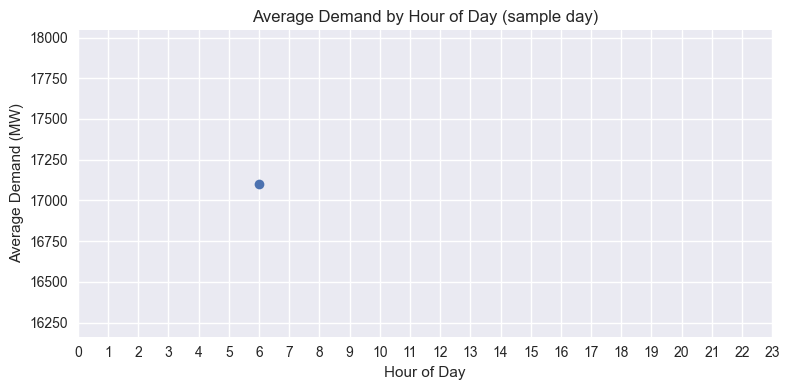

hour_of_day
6    17103.45
Name: demand_mw, dtype: float64

In [8]:
hourly_profile = df.groupby("hour_of_day")["demand_mw"].mean()

plt.figure(figsize=(8, 4))
plt.plot(hourly_profile.index, hourly_profile.values, marker="o")
plt.title("Average Demand by Hour of Day (sample day)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Demand (MW)")
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

hourly_profile

## Prepare a regular time series for modeling

In [9]:
# Set timestamp as index
ts = df.set_index("timestamp")["demand_mw"].sort_index()

# If you want hourly averages for a smoother series:
ts_hourly = ts.resample("H").mean().dropna()

print("5-min series length:", len(ts))
print("Hourly series length:", len(ts_hourly))

ts_hourly.head()

5-min series length: 12
Hourly series length: 1


timestamp
2025-11-14 06:00:00    17103.45
Freq: H, Name: demand_mw, dtype: float64

## Train–test split (last few hours as test)

In [10]:
# Use 5-minute series (ts) for modeling
s = ts.copy()  # ts = df.set_index("timestamp")["demand_mw"]

print("Total points in series:", len(s))
print("First timestamp:", s.index.min())
print("Last timestamp :", s.index.max())

# If we have very little data, we can't do a serious ARIMA.
if len(s) < 20:
    print("Not enough data for a real ARIMA model. I will still do a tiny demo split.")
    test_size = max(1, len(s) // 3)  # at least 1 point, at most 1/3 of data
else:
    # Use 20% of data as test, at least 5 points
    test_size = max(5, int(len(s) * 0.2))

train = s.iloc[:-test_size]
test = s.iloc[-test_size:]

print("Train size:", len(train))
print("Test size :", len(test))

Total points in series: 12
First timestamp: 2025-11-14 06:00:00
Last timestamp : 2025-11-14 06:55:00
Not enough data for a real ARIMA model. I will still do a tiny demo split.
Train size: 8
Test size : 4


## Simple ARIMA model (baseline forecast)

In [11]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import statsmodels.api as sm
import pandas as pd

if len(train) < 10:
    print("Train set too small for ARIMA. Using a simple naive forecast instead.")
    # Naive forecast: repeat last train value for all test points
    forecast = pd.Series([train.iloc[-1]] * len(test), index=test.index)
else:
    # Simple ARIMA model (small order)
    model = sm.tsa.ARIMA(train, order=(1, 0, 1))
    results = model.fit()
    forecast = results.forecast(steps=len(test))

print("Forecast length:", len(forecast))

Train set too small for ARIMA. Using a simple naive forecast instead.
Forecast length: 4


## Plot forecast vs actual

MAE : 91.625
MAPE: 0.005302421601801997


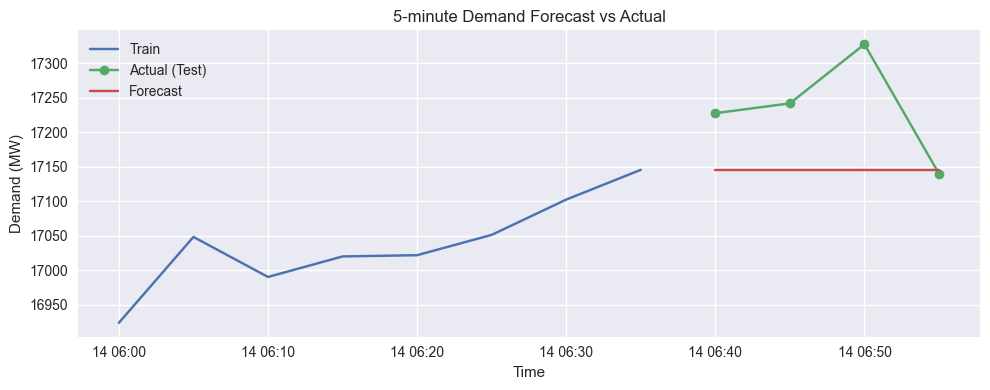

In [12]:
if len(test) > 0 and len(forecast) > 0:
    mae = mean_absolute_error(test, forecast)
    mape = mean_absolute_percentage_error(test, forecast)

    print("MAE :", mae)
    print("MAPE:", mape)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(train.index, train.values, label="Train")
    plt.plot(test.index, test.values, label="Actual (Test)", marker="o")
    plt.plot(test.index, forecast.values, label="Forecast", marker="x")
    plt.title("5-minute Demand Forecast vs Actual")
    plt.xlabel("Time")
    plt.ylabel("Demand (MW)")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Test or forecast is empty – cannot compute metrics. Please load more data (more rows).")
